In [7]:
import os
os.chdir('/home/fsboedij/Data/MouseAtlas')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import copy
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gdown
import sankey
import anndata
import pandas as pd
import pandas as pd
from pySankey.sankey import sankey
from matplotlib.pyplot import rc_context
import seaborn as sns
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(5, 5))
torch.set_printoptions(precision=10, sci_mode=False, edgeitems=12)
pd.options.mode.chained_assignment = None
import scipy.sparse as sp

In [8]:
directory = '/home/fsboedij/Data/MouseAtlas/Data/Individual_studies_final/preQC'

In [9]:
#Load each study objects and compile them in a list
studies = []
# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.h5ad'):  # Check if the file is a .h5ad file
        print(filename)
        filepath = os.path.join(directory, filename)
        adata_obj = sc.read(filepath)  # Load the .h5ad file
        #Replacing '.' to '-' to harmonise gene names in each study
        adata_obj.var_names = adata_obj.var_names.str.replace('.','-')
        adata_obj.X.data=adata_obj.raw.X.data.copy()
        adata_obj.layers['raw']=adata_obj.raw.X.copy()
        print(adata_obj.shape)
        print(adata_obj.X.data)
        studies.append(adata_obj) 

len(studies)

Mouse_fibrosis_final.h5ad
(18975, 25127)
[ 1.  1. 10.  7.  2.  1.  1. ...  1.  4.  1.  1.  2.  2.  1.]
Ageing_final.h5ad
(14450, 21969)
[3. 1. 1. 1. 1. 1. 1. ... 1. 1. 1. 2. 1. 1. 1.]
Mouse_Radiation_final.h5ad
(6662, 27998)
[ 7.  1.  1.  2.  1.  1.  2. ... 14.  5.  9. 16.  1.  6.  4.]
Mouse_covid_final.h5ad
(37306, 40051)
[1. 1. 1. 2. 3. 1. 1. ... 1. 1. 3. 1. 1. 1. 1.]
Mouse_TumorKO_final.h5ad
(16350, 32288)
[  1.   1.   1.   1.   2.  26.   2. ...   1.  45.   1.   1.  22. 515. 127.]
Mouse_copd_covid_final.h5ad
(28248, 35544)
[1. 1. 2. 2. 1. 1. 2. ... 1. 1. 1. 3. 1. 1. 1.]
Mouse_Cancer_final.h5ad
(15939, 28205)
[ 1.  1.  1.  2.  1.  1.  1. ...  6.  4.  3. 10.  4.  1.  7.]
Mouse_Hypoxia_final.h5ad
(11012, 54233)
[1. 2. 2. 1. 4. 1. 2. ... 1. 1. 6. 1. 3. 1. 7.]
Mouse_Fibro_Age_final.h5ad
(328868, 36532)
[ 1.  1.  1.  1.  1.  1.  1. ...  1.  9.  2.  2.  2.  2. 49.]
Mouse_SevereAsthma_final.h5ad
(72260, 32285)
[1. 1. 2. 1. 1. 1. 2. ... 3. 5. 6. 2. 2. 1. 1.]
Mouse_Herpesvirus.h5ad
(30881, 22

17

In [27]:
for adata in studies:
    print(adata.obs['study'].iloc[0])  

Mouse_fibrosis
Mouse_Age
Mouse_Radiation
Mouse_Covid
Mouse_TumorKO
Mouse_Copd_Covid
Mouse_Cancer
Mouse_Hypoxia
Mouse_Fibro_Age
Mouse_asthma
Mouse_Herpesvirus
Mouse_influenza
Mouse_Copd
Mouse_COPD_SHAM_SARSCov2
Mouse_Post_Sendai
Mouse_TB
Mouse_Hyperoxia


In [28]:
#Make sure the integration was done in the exact same order
order = ["Covid","Copd_Covid","Copd","Age","COPD_SHAM_SARSCov2","Herpesvirus","Hyperoxia",\
	"TB","Cancer","Hypoxia","Radiation","Post_Sendai","TumorKO","fibrosis","asthma","Fibro_Age","influenza"]

order = ["Mouse_" +item for item in order]

print(order)

['Mouse_Covid', 'Mouse_Copd_Covid', 'Mouse_Copd', 'Mouse_Age', 'Mouse_COPD_SHAM_SARSCov2', 'Mouse_Herpesvirus', 'Mouse_Hyperoxia', 'Mouse_TB', 'Mouse_Cancer', 'Mouse_Hypoxia', 'Mouse_Radiation', 'Mouse_Post_Sendai', 'Mouse_TumorKO', 'Mouse_fibrosis', 'Mouse_asthma', 'Mouse_Fibro_Age', 'Mouse_influenza']


In [29]:
#Reordering healthy and disease subsets
def get_study_name(adata):
    return adata.obs['study'].iloc[0]  # Assuming study is the same for all obs in adata

    # Create a dictionary with study names as keys and AnnData objects as values
adata_dict = {get_study_name(adata): adata for adata in studies}

    # Reorder the list of AnnData objects based on the custom order
studies= [adata_dict[study] for study in order if study in adata_dict]

print("Subsets order:")
for adata in studies:
    print(adata.obs['study'].iloc[0])  # Should match the order list

Subsets order:
Mouse_Covid
Mouse_Copd_Covid
Mouse_Copd
Mouse_Age
Mouse_COPD_SHAM_SARSCov2
Mouse_Herpesvirus
Mouse_Hyperoxia
Mouse_TB
Mouse_Cancer
Mouse_Hypoxia
Mouse_Radiation
Mouse_Post_Sendai
Mouse_TumorKO
Mouse_fibrosis
Mouse_asthma
Mouse_Fibro_Age
Mouse_influenza


In [31]:
#Combine each study into one adata containing all studies and all genes
adata = studies[0].concatenate(
    studies[1:],  # Remaining AnnData objects
    index_unique=None,  # Keep cell indices unique
    join='outer',  # Include all genes (fill missing with fill_value)
    fill_value=0,  # Fill missing values with 0
    batch_key=None
)
print(adata)
print(adata.X.data)
print(adata.raw.X.data)


AnnData object with n_obs × n_vars = 885541 × 70224
    obs: 'nCount_covid', 'nFeature_covid', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'CellStatus', 'pANN_0.25_0.09_241', 'DF.classifications_0.25_0.09_241', 'DoubletStatus', 'pANN_0.25_0.09_520', 'DF.classifications_0.25_0.09_520', 'pANN_0.25_0.09_148', 'DF.classifications_0.25_0.09_148', 'pANN_0.25_0.09_368', 'DF.classifications_0.25_0.09_368', 'pANN_0.25_0.09_1110', 'DF.classifications_0.25_0.09_1110', 'pANN_0.25_0.09_33', 'DF.classifications_0.25_0.09_33', 'pANN_0.25_0.09_1015', 'DF.classifications_0.25_0.09_1015', 'nGene', 'nUMI', 'Group', 'res.0', 'res.0.1', 'res.0.2', 'res.0.3', 'res.0.4', 'res.0.5', 'res.0.6', 'res.0.7', 'res.0.8', 'res.0.9', 'res.1', 'seurat_clusters', 'infection', 'Sample.Gender', 'percent.hb', 'percent.rp', 'cluster_labels_res.0.4', 'predicted.classification_Angelidis.score', 'predicted.classification_Angelidis', 'mouseRNA.labels', 'immgen.labels', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_s

In [32]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))

In [33]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

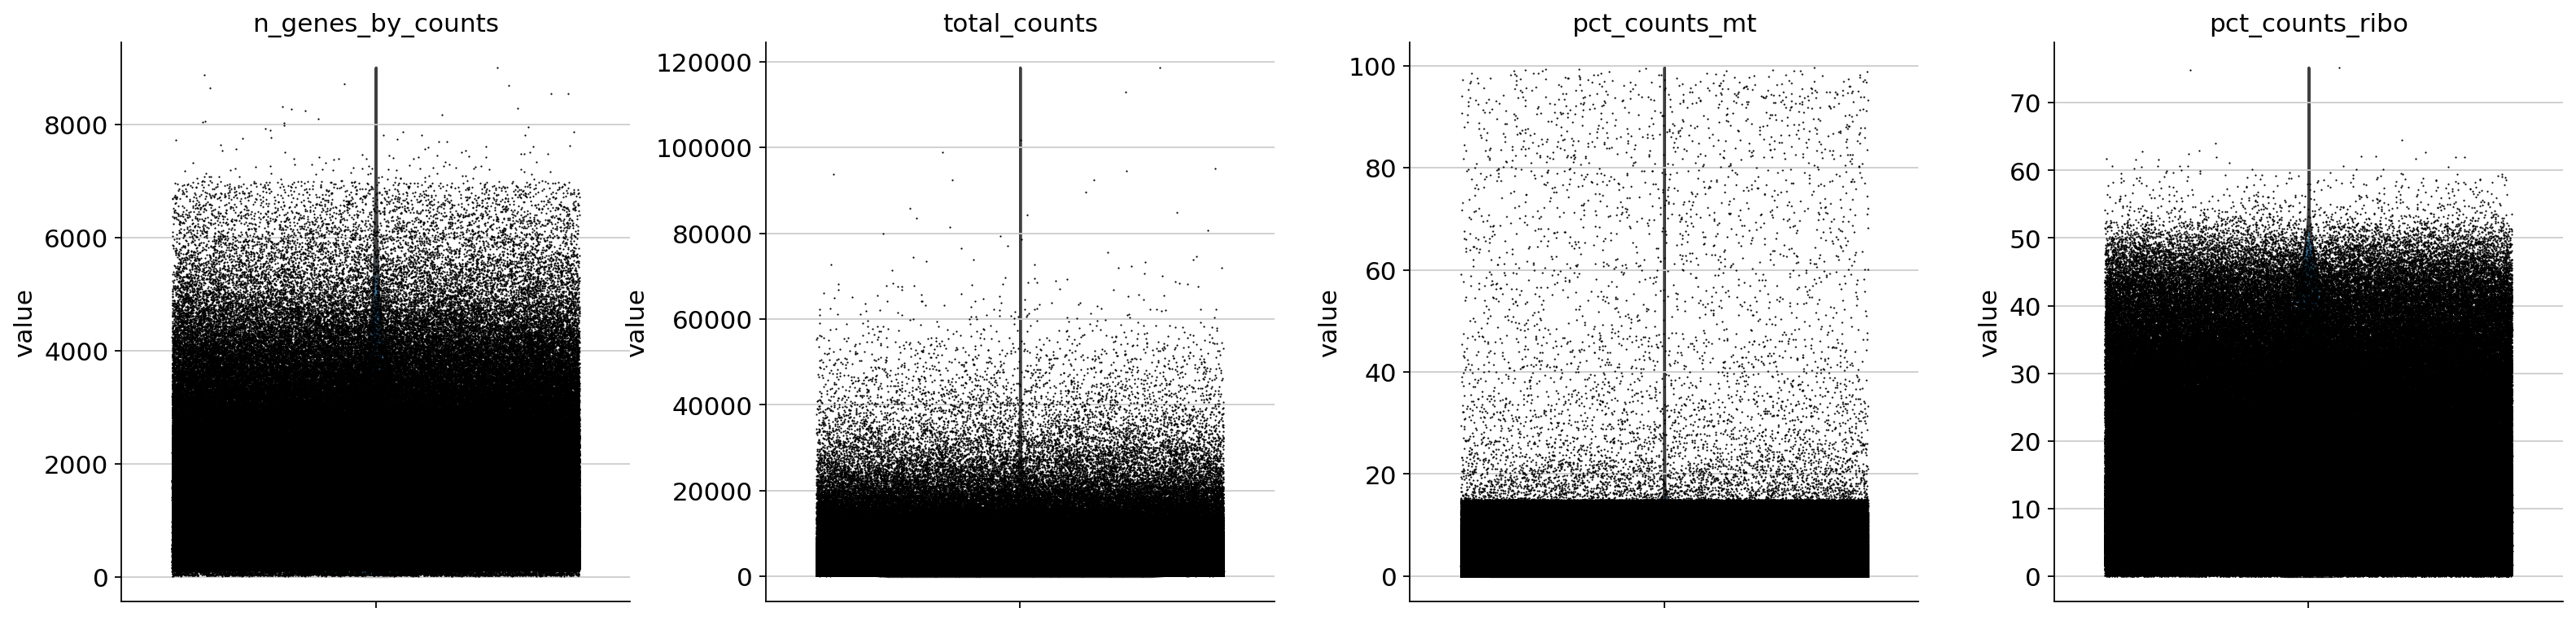

In [34]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True,save='counts.png')

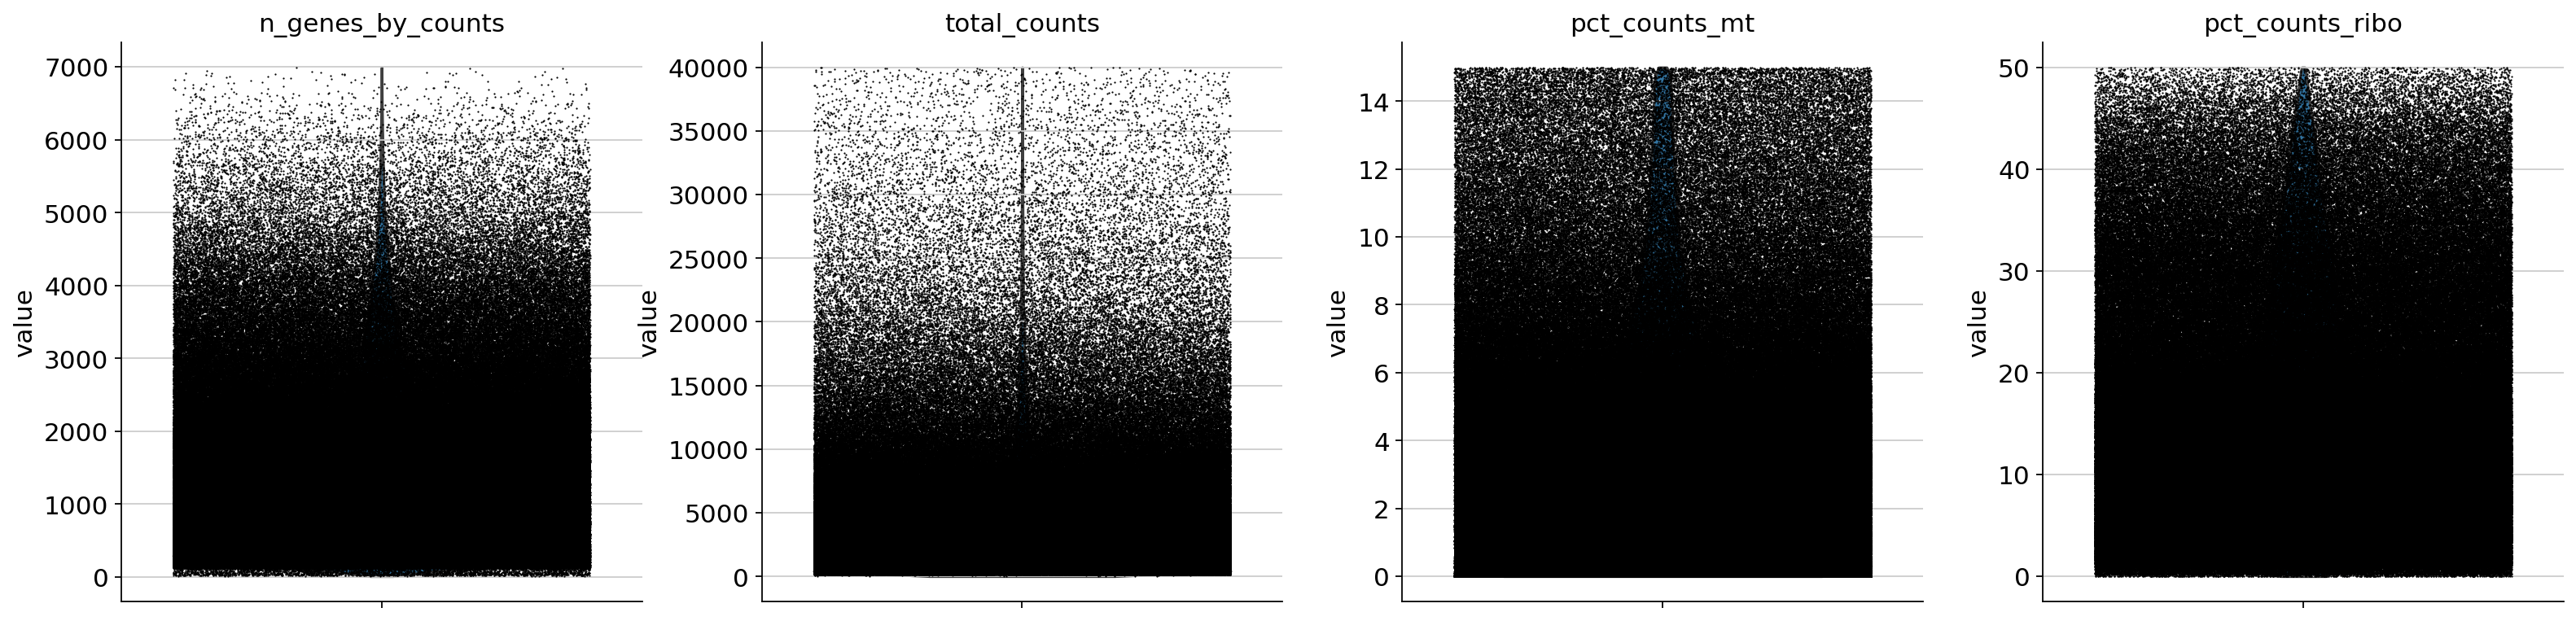

In [35]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.pct_counts_ribo < 50, :]


sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True,save='counts_postqc.png')

In [36]:
print(adata.X.data)
print(adata.raw.X.data)

[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]


In [37]:
print(adata.X.shape)
print(adata.raw.X.shape)

(876543, 70224)
(876543, 103066)


In [38]:
n_cells_pre = adata.shape[0]
sc.pp.filter_cells(adata, min_genes=200)
n_cells_post = adata.shape[0]
print("Number of cells removed: " + str(n_cells_pre - n_cells_post))
print("Number of cells pre-filtering: " + str(n_cells_pre))
print("Number of cells post filtering: " + str(n_cells_post))
adata.shape

filtered out 46130 cells that have less than 200 genes expressed
Number of cells removed: 46130
Number of cells pre-filtering: 876543
Number of cells post filtering: 830413


(830413, 70224)

In [39]:
print(adata.X.data)
print(adata.raw.X.data)
print(adata.layers['raw'].data)

[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]


Then to check for the low genes

In [40]:
print(adata.X.shape)
print(adata.raw.X.shape)

(830413, 70224)
(830413, 103066)


In [41]:
n_genes_pre = adata.shape[1]
sc.pp.filter_genes(adata, min_cells=10)
n_genes_post = adata.shape[1]
print("Number of genes removed: " + str(n_genes_pre - n_genes_post))
print("Number of genes pre-filtering: " + str(n_genes_pre))
print("Number of genes post filtering: " + str(n_genes_post))
adata.shape

filtered out 25431 genes that are detected in less than 10 cells
Number of genes removed: 25431
Number of genes pre-filtering: 70224
Number of genes post filtering: 44793


(830413, 44793)

In [42]:
#adata.raw=adata
print(adata.X.data)
print(adata.raw.X.data)
print(adata.layers['raw'].data)

[ 1.  1.  1. 10.  1.  1.  2. ...  1.  2.  1.  1.  1.  1. 11.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]


In [43]:
print(adata.X.shape)
print(adata.raw.X.shape)

(830413, 44793)
(830413, 103066)


In [44]:
# Convert all columns to string type
for col in adata.obs.columns:
    adata.obs[col] = adata.obs[col].astype(str)
adata.write('Data/step1_postQC_postfilter_final.h5ad')
print('filtered adata saved')

filtered adata saved


In [6]:
print(adata.X.data)
print(adata.raw.X.data)
print(adata.layers['raw'].data)

[ 1.  1.  1. 10.  1.  1.  2. ...  1.  2.  1.  1.  1.  1. 11.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]
[ 2.  2.  1.  1.  1. 82. 40. ...  2.  1.  3.  1.  1.  2.  5.]


In [27]:
len(adata.obs_names)

830413

In [28]:
#adata=sc.read("Data/step1_postQC_postfilter_final.h5ad")
for study in studies:
    print(np.unique(study.obs['study']))
    # Step 1: Find overlapping genes (common intersection of .var names)
    common_genes = study.var_names.intersection(adata.var_names)
    common_cells = study.obs_names.intersection(adata.obs_names)
    
    # Step 2: Subset both adata objects to keep only the common genes
    new_subset = study[:, common_genes]
    
    print(new_subset.X.data)
    print(new_subset.raw.X.data)
    print(new_subset.layers['raw'].data)

    new_subset = new_subset[common_cells,:]
   
    print(new_subset.shape)
    #print(new_subset.X.data)
    #new_subset.raw = new_subset.X.copy()
    study_name = "_".join(study.obs.study.unique())
   
# Save the file using the study name
    new_subset.write(f"Data/Individual_studies_final/postQC_2025/{study_name}.h5ad")


['Mouse_fibrosis']
[ 1.  1. 10.  7.  2.  1.  1. ...  1.  4.  1.  1.  2.  2.  1.]
[ 1.  1. 10.  7.  2.  1.  1. ...  1.  4.  1.  1.  2.  2.  1.]
[ 1.  1. 10.  7.  2.  1.  1. ...  1.  4.  1.  1.  2.  2.  1.]
(18134, 22186)
['Mouse_Age']
[3. 1. 1. 1. 1. 1. 1. ... 1. 1. 1. 2. 1. 1. 1.]
[3. 1. 1. 1. 1. 1. 1. ... 1. 1. 1. 2. 1. 1. 1.]
[3. 1. 1. 1. 1. 1. 1. ... 1. 1. 1. 2. 1. 1. 1.]
(14304, 20777)
['Mouse_Radiation']
[ 7.  1.  1.  2.  1.  1.  2. ... 14.  5.  9. 16.  1.  6.  4.]
[ 7.  1.  1.  2.  1.  1.  2. ... 14.  5.  9. 16.  1.  6.  4.]
[ 7.  1.  1.  2.  1.  1.  2. ... 14.  5.  9. 16.  1.  6.  4.]
(6345, 24660)
['Mouse_Covid']
[1. 1. 1. 2. 3. 1. 1. ... 1. 1. 3. 1. 1. 1. 1.]
[1. 1. 1. 2. 3. 1. 1. ... 1. 1. 3. 1. 1. 1. 1.]
[1. 1. 1. 2. 3. 1. 1. ... 1. 1. 3. 1. 1. 1. 1.]
(37280, 34493)
['Mouse_TumorKO']
[  1.   1.   1.   1.   2.  26.   2. ...   1.  45.   1.   1.  22. 515. 127.]
[  1.   1.   1.   1.   2.  26.   2. ...   1.  45.   1.   1.  22. 515. 127.]
[  1.   1.   1.   1.   2.  26.   2. ...   

In [25]:
print(study.X.data)
print(new_subset.X.data)

[ 1.  1.  2.  2.  4.  2.  2. ... 54.  2.  5. 10.  4.  1. 40.]
[ 1.  1.  2.  2.  4.  2.  2. ... 54.  2.  5. 10.  4.  1. 40.]
